# Линейная регрессия

### Краткий конспект теории и выполнение практических заданий 

Структура:  
1. Реализация лнейной регрессии при помощи матричных операций и градиентного спуска (прогнозирование стоимости дома в Бостоне):  
     1.1. Реализация линейной регрессии с использованием матричных операций.  
     1.2. Реализация линейной регрессии с использованием методов оптимизации.  
     1.3. Использование матричных операций VS градиентного спуска в линейной регрессии.  
     1.4. Превращение линейной модели в нелинейную.  
     1.5. Добавление регуляризатора в линейную регрессию.
2. Реализация линейной регрессии с помощью средств библиотеки sklearn.

In [ ]:
# Загрузим необходимые библиотки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, roc_auc_score, roc_curve
from sklearn.datasets import load_boston

## 1. Реализация лнейной регрессии при помощи матричных операций и градиентного спуска  (прогнозирование стоимости дома в Бостоне)

In [3]:
# Загрузим датасет Load_boston
data_boston = load_boston()
print(f"Размер датасета: {data_boston['data'].shape}")

# Посмотрим описание к датасету
print(f"Описание данных: \n{data_boston['DESCR']}")

Размер датасета: (506, 13)
Описание данных: 
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value proper

## 1.1. Реализация линейной регрессии с использованием матричных операций

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где $X$ — матрица объекты-признаки, $y$ — вектор целевых значений, соответствующих $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$

In [5]:
# Реализуем функцию для получения theta с помощью операций линейной алгебры библиотеки Numpy
def linreg_linear(X, y):
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    return theta

In [7]:
# Подготовим данные для построения модели, сгененируем столбец из единиц (bias линейной модели)
X, y = data_boston['data'], data_boston['target']
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
print(f'Размер X: {X.shape} \nРазмер y: {y.shape}')

# Вычислим параметр theta
theta = linreg_linear(X, y)
print(f'\nРазмер вектора theta: {theta.shape}')

# Сделаем предсказания для всей выборки
y_pred = X.dot(theta)
print(f'Размер y_pred: {y.shape}')

Размер X: (506, 14) 
Размер y: (506,)

Размер вектора theta: (14,)
Размер y_pred: (506,)


MSE = 21.89, RMSE = 4.68


None

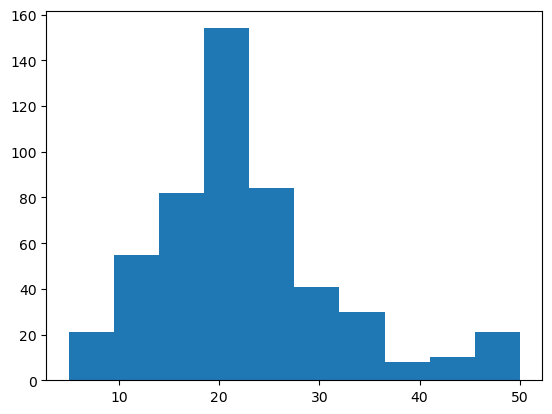

In [10]:
# Функция для подсчета значения ошибок MSE и RMSE 
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
    
# Посчитаем значение метрик 
display(print_regression_metrics(y, y_pred))

# Посмотрим, какие значения принимает y
plt.hist(y)

В данном случае мы обучили модель и посчитали метрики на одних и тех же данных. Это не совсем правильная тактика, т.к. алгоритм делает предсказания на уже изученном наборе данных. **Разделим выборку на обучающую и валидационную**.

In [11]:
# Разбобьем выборку на train и valid, вычислим theta, сделаем предсказания и посчитаем метрики MSE и RMSE
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

print('Значения метрик на тренировочной выборке:')
print_regression_metrics(y_train, y_train_pred)
print(f'Значения метрик на валидационной выборке:')
print_regression_metrics(y_valid, y_pred)

Значения метрик на тренировочной выборке:
MSE = 21.26, RMSE = 4.61
Значения метрик на валидационной выборке:
MSE = 25.94, RMSE = 5.09


Значения метрик свидетельствуют о том, что модель переобучилась. Модель работает относительно нормально на обучающей выборке, но плохо на валидационной.

In [12]:
# Обучим модель linearRegression из библиотеки sklearn и посмотрим на результат
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


## 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии при помощи методов оптимизации будем использовать **среднеквадратичную функцию потерь**   
([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [13]:
# Реализуем функцию вычисления градиента квадратичной функции потерь MSE
def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    return grad

# Реализуем функцию, осуществляющую градиентный шаг
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad


# Реализуем функцию цикла градиентного спуска
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)   
    return theta

In [14]:
# Разобьем таблицу данных на матрицы X и y
X, y = data_boston['data'], data_boston['target']

# Добавим фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

# Оптимизируем параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)
print(f'Размер theta: {theta.shape}')
theta

Размер theta: (14,)


array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [15]:
# Проверим максимальные значения по каждому признаку в данных
print(f'Максимальные значения по каждому признаку в данных: \n{X.max(axis = 0)}')

# Посмотрим, чему равно наибольшее стандартное отклонение у признаков
print(f'\nНаибольшее стандартное отклонение у признаков: {np.max(X.std(axis = 0))}')
print(data_boston['feature_names'][np.argmax(X.std(axis = 0)) + 1])

Максимальные значения по каждому признаку в данных: 
[  1.      88.9762 100.      27.74     1.       0.871    8.78   100.
  12.1265  24.     711.      22.     396.9     37.97  ]

Наибольшее стандартное отклонение у признаков: 168.3704950393814
B


In [16]:
# Нормализуем даннные с помощью стандартной нормализации
X, y = data_boston['data'], data_boston['target']
X = (X - X.mean(axis = 0)) / X.std(axis = 0)

# Добавим фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis = 0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [18]:
# Оптимизируем theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)
print(f'Размер theta: {theta.shape}')
print(theta)

# Сделаем предсказания при полученных параметрах
y_pred = X.dot(theta)

# Посчитаем значение MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

Размер theta: (14,)
[ 2.25328063e+01 -9.21740195e-01  1.07033639e+00  1.06388396e-01
  6.86667316e-01 -2.05006416e+00  2.68062168e+00  1.40667969e-02
 -3.10608483e+00  2.57511475e+00 -1.97802851e+00 -2.05725099e+00
  8.48690321e-01 -3.74025884e+00]
MSE = 21.90, RMSE = 4.68


In [23]:
# Разобьем выборку на train/valid, оптимизируем theta, сделаем предсказания и посчитаем метрики MSE и RMSE
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 20.69, RMSE = 4.55


In [24]:
# Построим модель при помощи библиотеки sklearn. Обучим модель на всей выборке и посчитаем RMSE 
LR = LinearRegression().fit(X,y)
y_pred = LR.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### Очистим данные от строк, где значение признака "B" меньше 50 и посмотрим как изменится значение метрик качества 

In [30]:
df = pd.DataFrame(data_boston['data'], columns = data_boston['feature_names'])
print(f'Размер изначального датасета: {df.shape}')
df = df[df['B'] > 50]
print(f'Размер датасета после изменения: {df.shape}')

Размер изначального датасета: (506, 13)
Размер датасета после изменения: (486, 13)


In [31]:
df_target = pd.DataFrame(data_boston['target'])
df_target.rename(columns = {0: 'target'}, inplace = True)
df.insert(13, column = 'target', value = df_target['target'])
display(df.head())

# Разделим выборку, обучим модель линейной регрессии из sklearn и посчитаем метрики
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values     
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

linreg_model = LinearRegression().fit(X_train, y_train)
y_pred = linreg_model.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


MSE = 32.11, RMSE = 5.67


In [32]:
# Обучим модель линейной регрессии из sklearn и посчитаем метрики
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values     
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

linreg_model = LinearRegression().fit(X_train, y_train)
y_pred = linreg_model.predict(X_valid)

print_regression_metrics(y_valid, y_pred)

MSE = 17.60, RMSE = 4.20


## 1.3. Использование матричных операций vs градиентного спуска в лин. регрессии

Проведем замеры скорости работы алгоритмов на матричных операциях и на градиентном спуске. Предварительно найдем параметры для метода, основанного на градиентном спуске, так, чтобы значения метрик максимально совпадали со значениями в случае первого алгоритма.

In [59]:
# Функция для подсчета значения ошибок MSE и RMSE 
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

    
# Функция для подготовки датасета 
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)              # Нормализуем даннные с помощью стандартной нормализации
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])    # Добавим фиктивный столбец единиц (bias линейной модели)
    return X, y

In [60]:
# Обернем в класс линейную регрессию, реализованную методом матричных операций
class LinRegAlgebra():
    def __init__(self):
        self.theta = None
    
    def fit(self, X, y):
        self.theta = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    
    def predict(self, X):
        return X.dot(self.theta)

In [63]:
X, y = prepare_boston_data()

linreg_alg = LinRegAlgebra()
linreg_alg.fit(X, y)
y_pred = linreg_alg.predict(X)

# Посчитаем значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


In [64]:
# Обернем в класс функции, реализующие оптимизацию градиентным спуском
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for i in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)
        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [65]:
class LinReg(RegOptimizer):
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        return grad
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')        
        y_pred = X.dot(self.theta)        
        return y_pred

In [66]:
linreg_crit = LinReg(0.2, 1000)
linreg_crit.fit(X, y)
y_pred = linreg_crit.predict(X)

# Посчитаем значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


In [72]:
%timeit linreg_alg.fit(X, y)

46.2 µs ± 4.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [73]:
%timeit linreg_crit.fit(X, y)

15.9 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
15000 / 64

234.375

Как видно из результатов эксперимента, реализация на матричных операциях опережает реализацию на градиентном спуске. Но всегда ли это так и какие подводные камни могут быть? Ниже приведен набор случаев, при которых версия с градентным спуском предпочтительнее:

1. Градиентный спуск работает быстрее в случае матриц с большим количеством признаков. Основная по сложности операция — нахождение обратной матрицы $(X^T X)^{-1}$.
1. Нахождение обратной матрицы может также потребовать больше оперативной памяти, что иногда является не приемлемым.
1. Матричные операции могут также проигрывать и в случае небольших объемов данных, но при плохой параллельной реализации или недостаточных ресурсах.
1. Градиентный спуск может быть усовершенствован до **стохастического градиентного спуска**, при котором данные для оптимизации подгружаются небольшими наборами, что уменьшает требования по памяти.
1. В некоторых случаях (например, в случае линейно-зависимых строк) алгебраический способ решения не будет работать совсем в виду невозможности найти обратную матрицу.

## 1.4. Превращение линейной модели в нелинейную

Нелинейные зависимости в данных встречаются намного чаще линейных. На самом деле простейшая линейная регрессия способна обнаруживать нелинейные зависимости. Для этого необходимо рассмотреть дополнительные признаки, полученные из исходных применением различных нелинейных функций. 

**Добавим два новых признака:**
  - возьмем корень из признака RM (среднее число комнат на сожителя)
  - возведем в куб значения признака AGE

Всевозможных комбинаций признаков и примененных к ним функций неограниченное количество.

In [81]:
def prepare_boston_data_new():
    data = load_boston()
    X, y = data['data'], data['target']
    
    # Модифицируем признаки - возьмем корень из признака RM и возведем в куб значения признака AGE
    X = np.hstack([X, np.sqrt(X[:, 5:6]), X[:, 6:7] ** 3])
    
    # Нормализуем даннные при помощи стандартной нормализации
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    
    # Добавим фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [82]:
def train_validate(X, y):
    # Разделим данные на train / valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 1)

    # Создадим и обучим линейную регрессию
    linreg_alg = LinRegAlgebra()
    linreg_alg.fit(X_train, y_train)

    # Сделаем предсказания по валидционной выборке
    y_pred = linreg_alg.predict(X_valid)

    # Посчитаем значение ошибок MSE и RMSE для валидационных данных
    print_regression_metrics(y_valid, y_pred)

In [91]:
# Подготовим данные без модификации признаков
X, y = prepare_boston_data()

# Проведем эксперимент
train_validate(X, y)

MSE = 23.38, RMSE = 4.84


In [94]:
# Подготовим данные с модификацией признаков
X, y = prepare_boston_data_new()

# Проведем эксперимент
train_validate(X, y)

MSE = 14.28, RMSE = 3.78


Как видно из результатов, мы добились улучшения точности предсказаний приблизительно на 40%, добавив пару нелинейных признаков к имеющимся. Данный результат можно улучшать и дальше.

#### Добавим к признакам нелинейной модели квадрат признака DIS, обучим модель и посчитаем метрики.

In [108]:
data = load_boston()
X, y = data['data'], data['target']
    
# Модифицируем признаки (корень признака RM, куб признака AGE и квадрат признака DIS)
X = np.hstack([X, np.sqrt(X[:, 5:6]), X[:, 6:7]**3, X[:, 7:8]**2])

# Нормализуем даннные с помощью стандартной нормализации
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    
# Добавим фиктивный столбец единиц (bias линейной модели), обучим модель и сделаем предсказание
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
train_validate(X, y)

MSE = 13.59, RMSE = 3.69


Уберем нормализацию, оставим добавленные признаки на основе RM и AGE, посчитаем значение метрик.

In [109]:
X, y = data['data'], data['target']
X = np.hstack([X, np.sqrt(X[:, 5:6]), X[:, 6:7]**3])
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
train_validate(X, y)

MSE = 14.28, RMSE = 3.78


## 1.5. Добавление регуляризатора в линейную регрессию

В случаях линейной и логистической регрессии добавляют к функции ошибки регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept / bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

После добавления регуляризации функция ошибки линейной регрессии выглядит следующим образом:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$
А ее градиент по параметру $\theta$:
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [125]:
class LinRegRegularized(LinReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LinRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        grad_term = self._lambd * np.mean(theta)
        return grad + grad_term

In [131]:
linreg = LinRegRegularized(alpha = 0.01, lambd = 0.05, n_iters = 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [132]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 19.11, RMSE = 4.37


## 2. Реализация линейной регрессии с помощью средств библиотеки sklearn 

**Предскажем стоимость квартир с при помощи модели sklearn.**    
- используем тренировочный датасет data_flats.    
- выполним простую предобработку данных,    
- обучим линейную регрессию,    
- посмотрим на качество модели.

,id,full_sq,life_sq,floor,preschool_education_centers_raion,school_education_centers_raion,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,...,shopping_centers_raion,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,mkad_km,bulvar_ring_km,kremlin_km,price_doc
0,1,43,27.0,4.0,5,5,0,0,7,3,...,16,1.131260,0.145700,0.177975,2.158587,0.600973,1.422391,13.675657,15.156211,5850000
1,2,34,19.0,3.0,5,8,0,0,6,1,...,3,0.635053,0.147754,0.273345,0.550690,0.065321,9.503405,8.132640,8.698054,6000000
2,3,43,29.0,2.0,4,7,0,0,5,1,...,0,1.445960,0.049102,0.158072,0.374848,0.453172,5.604800,8.054252,9.067885,5700000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30469 entries, 0 to 30468
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     30469 non-null  int64  
 1   full_sq                                30469 non-null  int64  
 2   life_sq                                24086 non-null  float64
 3   floor                                  30302 non-null  float64
 4   preschool_education_centers_raion      30469 non-null  int64  
 5   school_education_centers_raion         30469 non-null  int64  
 6   school_education_centers_top_20_raion  30469 non-null  int64  
 7   university_top_20_raion                30469 non-null  int64  
 8   sport_objects_raion                    30469 non-null  int64  
 9   additional_education_raion             30469 non-null  int64  
 10  culture_objects_top_25_raion           30469 non-null  int64  
 11  sh

None

id                                          0
full_sq                                     0
life_sq                                  6383
floor                                     167
preschool_education_centers_raion           0
school_education_centers_raion              0
school_education_centers_top_20_raion       0
university_top_20_raion                     0
sport_objects_raion                         0
additional_education_raion                  0
culture_objects_top_25_raion                0
shopping_centers_raion                      0
metro_km_walk                              25
kindergarten_km                             0
school_km                                   0
park_km                                     0
green_zone_km                               0
mkad_km                                     0
bulvar_ring_km                              0
kremlin_km                                  0
price_doc                                   0
dtype: int64

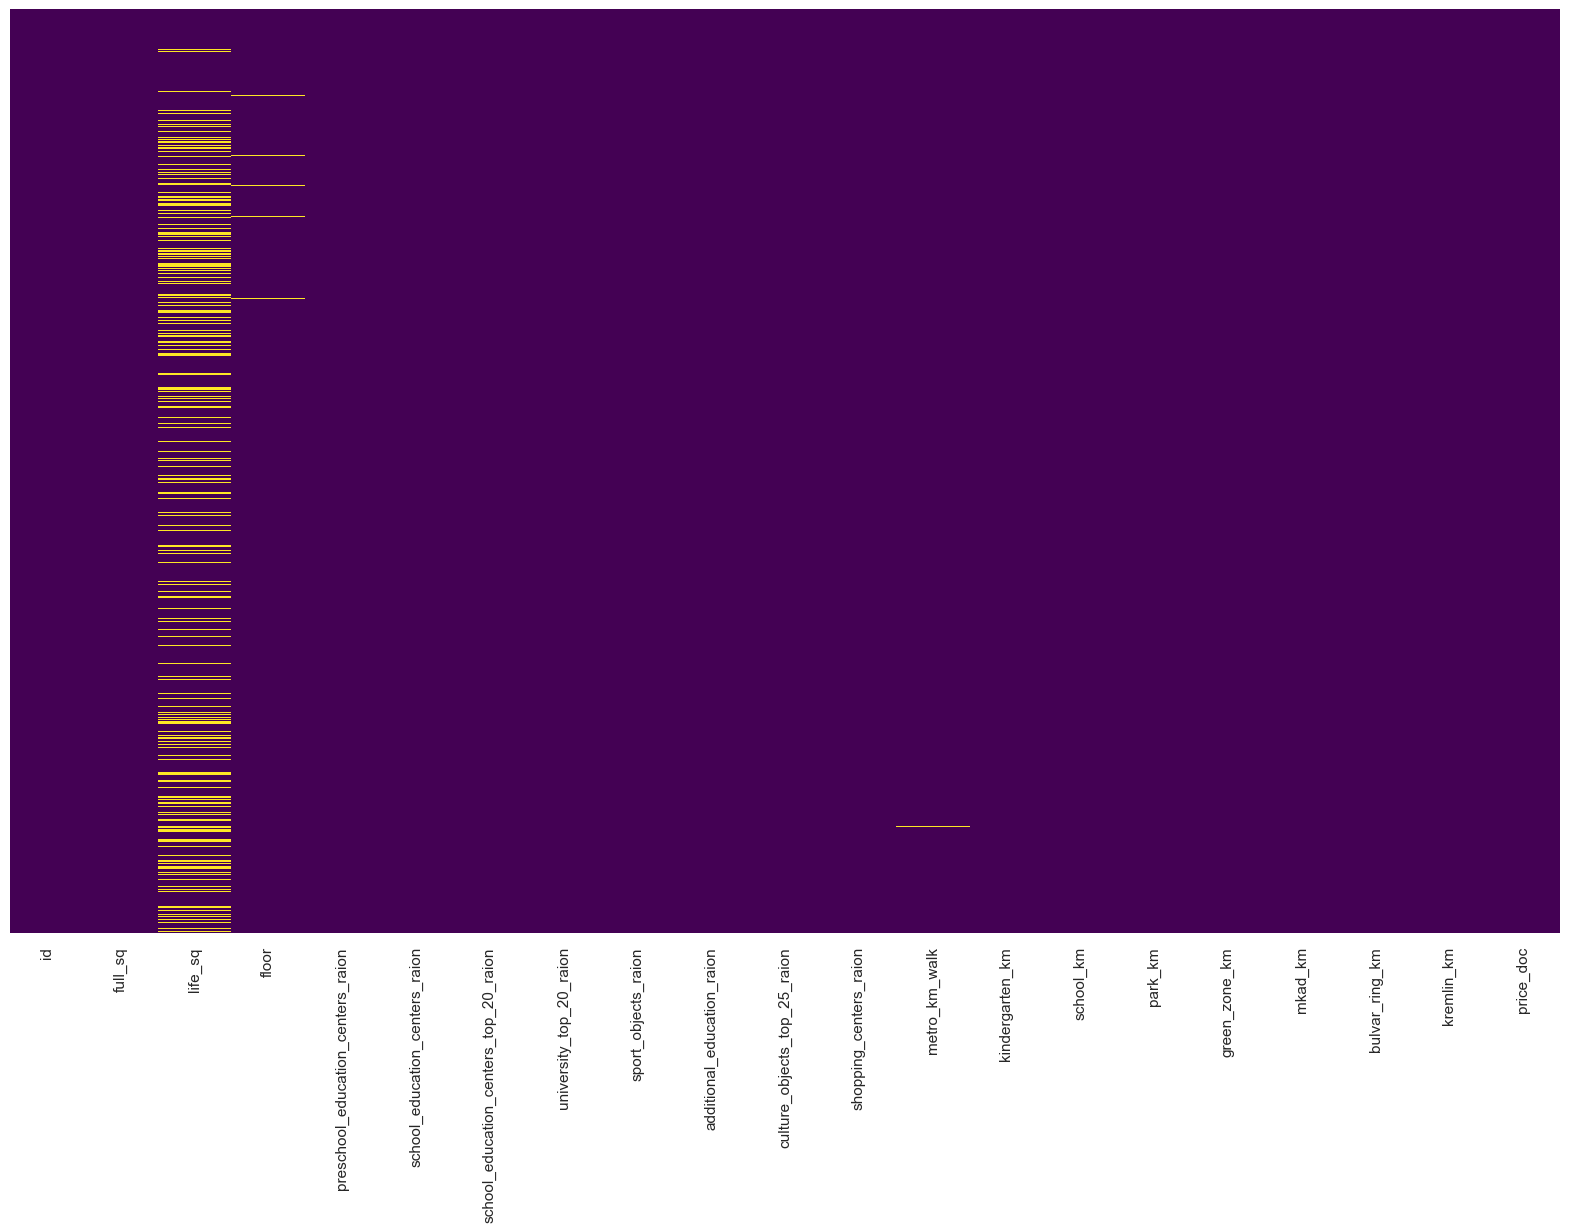

In [25]:
# Загрузим датасет и посмотрим на данные
data = pd.read_csv('data_flats.csv', sep = ';')
display(data.head(3))
display(data.info())  
display(data.isnull().sum())   

# Оценим визуально количество пропусков и их распределение
fig, ax = plt.subplots(figsize = (20, 12))   
sns_heatmap = sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Благодаря визуализации можно сразу оценить количество пропущенных значений и посмотреть, в каких переменных они встречаются. В данном случае желтым цветом показаны пропуски. Если пропуски встречаются в большом количестве только в нескольких переменных, которые не являются для нас важными, их можно удалить.

Большое количество пропусков наблюдается только в одном признаке — жилой площади. Не будем брать этот признак в модель.

- В датасете всего 20 признаков.  
- Независимая переменная, которую будем предсказывать - стоимость квартиры (price_doc).  
- Один из признаков — id, не несет смысловой нагрузки.  
- В данных есть пропуски (признаки: life_sq, floor, metro_km_walk).  
Большое количество пропусков наблюдается только в одном признаке — жилой площади. Не будем брать этот признак в модель.

<AxesSubplot:>

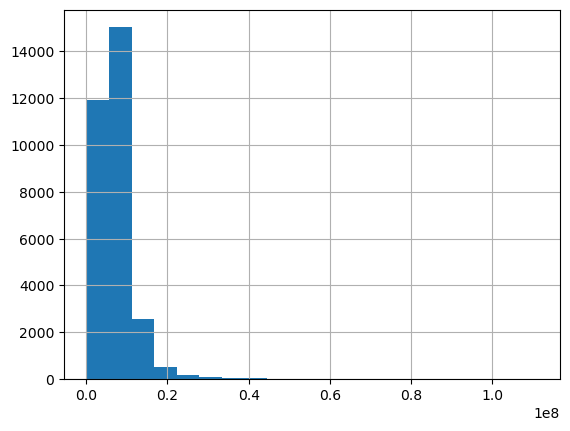

In [22]:
# Посмотрим на распределение целевой переменной 
data['price_doc'].hist(bins = 20)

У этого распределения есть проблема — слишком сильный перепад. Много квартир в среднем сегменте, но очень мало дорогих квартир.  
В таких случаях на практике часто логарифмируют переменную, чтобы уменьшить перепады и сгладить хвост.

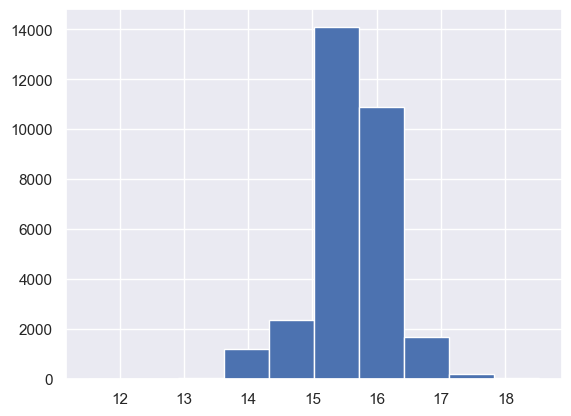

In [26]:
# Прологарифмируем целевую переменную 
data['price_doc'] = data['price_doc'].apply(lambda w: np.log(w + 1))
data.price_doc.hist()

**Отбор признаков**   
Необходимо проверить, нет ли мультиколлинеарности — сильной взаимосвязи между признаками. Для этого построим матрицу корреляций.

<AxesSubplot:>

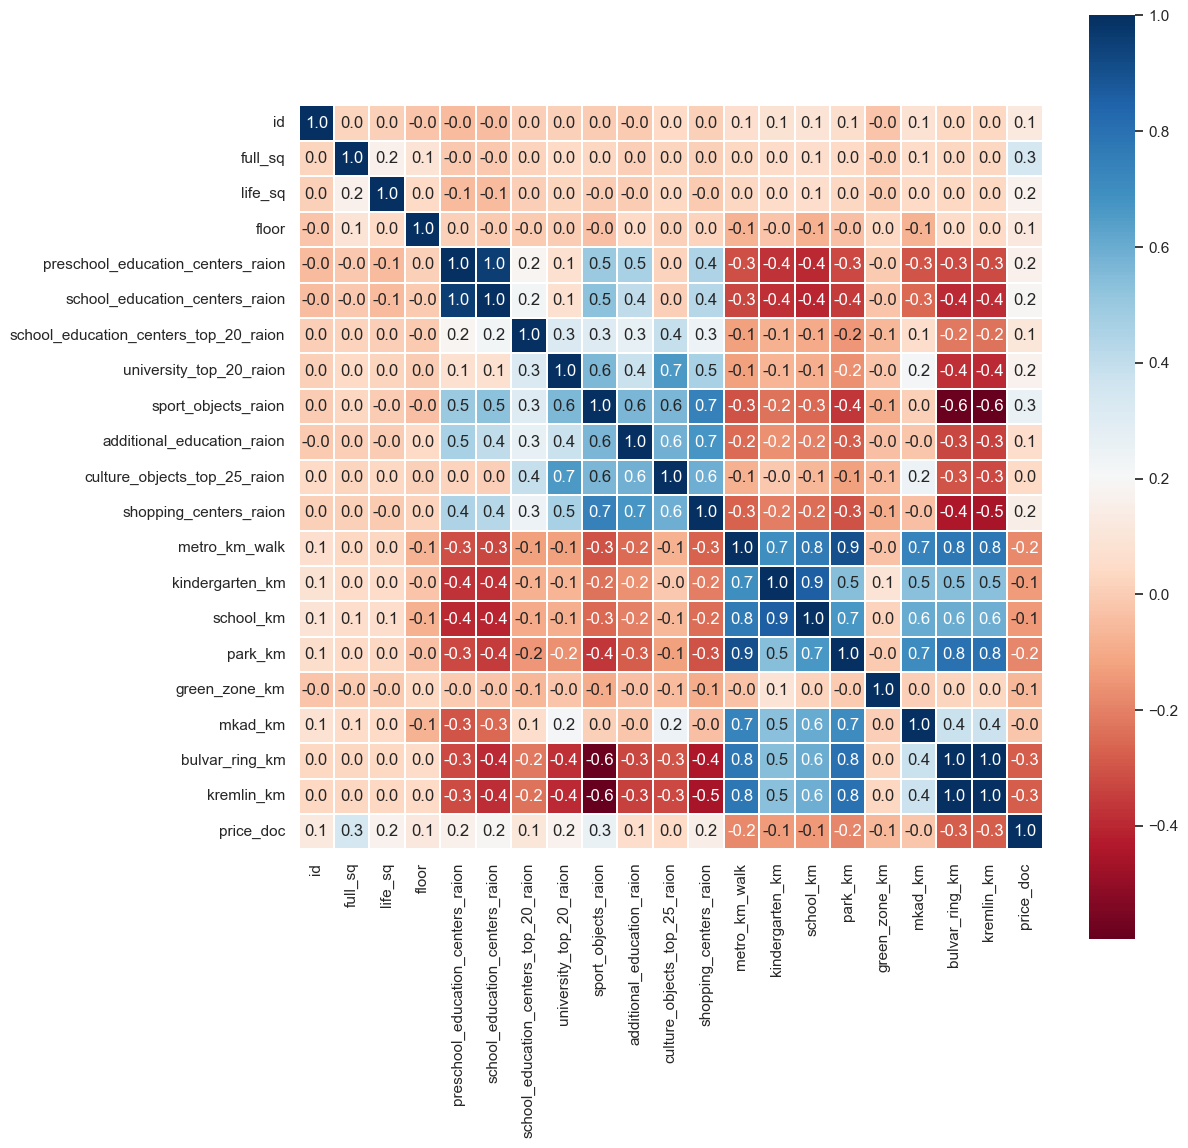

In [23]:
sns.set(font_scale = 1)
plt.subplots(figsize = (12, 12))
sns.heatmap(data.corr(), square = True, annot = True, fmt = ".1f", linewidths = 0.1, cmap = "RdBu")

#### Достаточно сильная взаимосвязь наблюдается у следующих пар признаков:

- Количество школ и количество детских садов. Довольно логично, так как в Москве детские сады обычно присоединены к школам.  
  Оставляем школы, т.к. у этого признака более высокая взаимосвязь с целевой переменной.

- Расстояние до школ и расстояние до детских садов. По сути, это естественным образом вытекает из предыдущего пункта. Оставляем расстояние до школ.

- Расстояние до парка и до метро. Рассуждая аналогично предыдущим парам, оставляем расстояние до метро.

- Расстояние до Кремля и до бульварного кольца. У них коэффициент корреляции равен 1, и их корреляция с целевой переменной одинаковая. Поэтому можем убрать любой признак. Убираем расстояние до Кремля.


Итак, неоходимо убрать пять признаков (четыре из-за мультиколлинеарности и жилую площадь из-за большого количества пропусков), остальные принаки оставляем.

In [21]:
data.columns

Index(['id', 'full_sq', 'life_sq', 'floor',
       'preschool_education_centers_raion', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25_raion', 'shopping_centers_raion',
       'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km',
       'green_zone_km', 'mkad_km', 'bulvar_ring_km', 'kremlin_km',
       'price_doc'],
      dtype='object')

- Удалим пять признаков и строки, где есть хотя бы один пропуск.  
- Обучим линейную регрессию (test_size = 0.2, random_state = 77). 
- Нормализуем отобранные признаки для тестовой и для обучающей выборки отдельно при помощи функции RobustScaler(), которая использует медианы и квантили для вычисления, поэтому не чувствительна к выбросам и может приводить к лучшим результатам. 
- Не будем брать id в качестве предиктора, поскольку он не несет никакой содержательной информации. 
- Вычислим MSE. При подсчете MSE необходимо найти экспоненциальную функцию от y, поскольку зависимая переменная была прологарифмирована. 

In [29]:
data.drop(['life_sq', 'preschool_education_centers_raion', 'kindergarten_km', 'park_km', 'kremlin_km', 'id'], 
          axis = 1, inplace = True)

# Посмотрим количество пропусков
print(f'Количество пропусков в датасете:{data.isnull().sum().sum()}')

# Удалим пропуски
data = data.dropna(axis = 0)
print(f'Количество пропусков в датасете после очистки:{data.isnull().sum().sum()}')

# Разобьем выборку
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 77)

# Нормализуем данные
skaler = RobustScaler()
X_train = skaler.fit_transform(X_train)
X_test = skaler.fit_transform(X_test)

# Обучим модель линейной регрессии. Сделаем предсказания и посчитаем MSE
lin_model = LinearRegression().fit(X_train, Y_train)
y_pred = lin_model.predict(X_test)

MSE = mean_squared_error(np.exp(Y_test), np.exp(y_pred))
print(f'Значение MSE = {MSE}') 

Количество пропусков в датасете:192
Количество пропусков в датасете после очистки:0
Значение MSE = 16647931507746.973


**Улучшение качества модели является отдельным широким и значимым аспектом в машинном обучении. Существует большое разнообразие методов повышения качества модели, среди которых можно отметить качественную предобработку данных, генерирование новых признаков, обогощение данных из сторонних источников и т.д.**